In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,  cross_val_score

from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../input/the-price-of-art/train.csv')
test = pd.read_csv('../input/the-price-of-art/test.csv')
sample = pd.read_csv('../input/the-price-of-art/sample.csv')

In [3]:
# split data into train and validation sets
train_set, validation_set = train_test_split(train, test_size=0.3, random_state=1)

# Data Cleaning

Because I did this in R the first time around, I'll need to clean the data up once more using Python. Most of it is similar to the way it was done in R. As before, I am going to define a few functions so it can be done reproducibly. 

First, I need to change errant variables to the correct `dtype`. I am also applying outlier correction on the 99.99th percentile of `height_cm`, which I found to have incorrect zero values for missing data:

In [4]:
def change_dtype_and_outliers(df):

    # Change into proper data types
    df['height_cm'] = pd.to_numeric(df['height_cm'], errors='coerce')
    df['width_cm'] = pd.to_numeric(df['width_cm'], errors='coerce')

    df['height_cm'] = df['height_cm'].astype('float')
    df['width_cm'] = df['width_cm'].astype('float')
    df['estimate_low_usd'] = df['estimate_low_usd'].astype('float')
    df['estimate_high_usd'] = df['estimate_high_usd'].astype('float')

    # A conditional statement is required for the target variables so this will eventually also work on test data
    if 'price_realized_usd' in df.columns:
        df['price_realized_usd'] = df['price_realized_usd'].astype('float')

    df['date'] = pd.to_datetime(df['date'])

    df['location'] = df['location'].astype('category')
    df['auction'] = df['auction'].astype('category')
    df['original_currency'] = df['original_currency'].astype('category')
    df['category'] = df['category'].astype('category')

    # Remove erroneous zeroes with NaN values
    df.replace(0, np.nan, inplace=True)

    # Outlier correction:

    # Write NA to height_cm if its value is higher than the 99th percentile
    upper_limit_height = df['height_cm'].quantile(0.9999, interpolation='linear')
    df.loc[df['height_cm'] > upper_limit_height, 'height_cm'] = np.nan

    ## Write NA to width_cm if its value is higher than the 99th percentile
    upper_limit_width = df['width_cm'].quantile(0.9999, interpolation='linear')
    df.loc[df['width_cm'] > upper_limit_width, 'width_cm'] = np.nan

    return df

train = change_dtype_and_outliers(train)

A quick check confirms the maximum value is not rediculous:

In [5]:
train['height_cm'].describe()

count    80552.000000
mean        69.444294
std         50.661511
min          0.800000
25%         33.000000
50%         54.800000
75%         90.500000
max        482.600000
Name: height_cm, dtype: float64

# Feature Engineering

**NLP**

In the previous homework, I followed basic feature engineering suggestions based on the number of characters in certain columns. On this next part of the project I thought - perhaps ambitiously - that Python's NLP packages could do one better and get the name of the country it has been exhibited in, or more.

I installed and played around with spaCy:

In [6]:
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz

In [7]:
import spacy
import en_core_web_sm
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

In [8]:
def extract_entities_provenance(row):
    
    if pd.isna(row["provenance"]):
        return row

    text = row["provenance"]
    doc = nlp(text)
    provenance_date = ""
    provenance_name = ""
    provenance_nationality = ""
    provenance_geopolitical = ""

    for ent in doc.ents:
        if ent.label_ == "DATE":
            provenance_date = ent.text
        elif ent.label_ == "PERSON":
            provenance_name = ent.text
        elif ent.label_ == "NORP":
            provenance_nationality = ent.text
        elif ent.label_ == "GPE" and not provenance_geopolitical:
            provenance_geopolitical = ent.text 

    row["provenance_date"] = provenance_date
    row["provenance_name"] = provenance_name
    row["provenance_nationality"] = provenance_nationality
    row["provenance_geopolitical"] = provenance_geopolitical

    return row

It shows some promise, but ultimately does not impress when trying to create a new column called `provenance_geopolitical`:

In [9]:
sampled_df = train.sample(n=10, random_state=1)

result_df = sampled_df.apply(extract_entities_provenance, axis=1)

print(result_df.loc[:, ['artist', 'provenance_geopolitical']])

                                                  artist  \
72778                      Richard Pettibone (b. 1938)\n   
78992                           Raoul Dufy (1877-1953)\n   
44156                        Fernand Léger (1881-1955)\n   
27275                       PIET MONDRIAN (1872-1944) \n   
56907  Felice Fortunato Biggi, called Felice de' Fior...   
54694                 BIKASH BHATTACHARJEE (1940-2006)\n   
74217  DOROTHEA SHARP, R.B.A., R.O.I., V.P.S.W.A. (BR...   
22046     Giuseppe Mattazzi (attivo nel XVIII secolo) \n   
90588       VITTORIO MARIA BIGARI (BOLOGNE 1692-1776) \n   
24215                   KARL EDMUND WALSER (1877-1943)\n   

      provenance_geopolitical  
72778                New York  
78992                  London  
44156                   Paris  
27275                   Paris  
56907                     NaN  
54694                  Bombay  
74217                 Glasgow  
22046                     NaN  
90588                     NaN  
24215              

Since it seems good at capturing geopolitical entities (`GPE`), I kept it for a later feature engineering step. You can see it labels locations pretty well:

In [10]:
sampled_df = train.sample(n=3, random_state=1)

def visualize_entities(row):
    doc = nlp(row["provenance"])
    displacy.render(doc, style="ent", jupyter=True)

sampled_df.apply(visualize_entities, axis=1)

72778    None
78992    None
44156    None
dtype: object

# Regular Expressions

A more reliable way to parse the names of artists seems to be regular expressions. The artist's names are quite hairy:

In [11]:
sampled_df = train.sample(n=10, random_state=1)
sampled_df['artist']

72778                        Richard Pettibone (b. 1938)\n
78992                             Raoul Dufy (1877-1953)\n
44156                          Fernand Léger (1881-1955)\n
27275                         PIET MONDRIAN (1872-1944) \n
56907    Felice Fortunato Biggi, called Felice de' Fior...
54694                   BIKASH BHATTACHARJEE (1940-2006)\n
74217    DOROTHEA SHARP, R.B.A., R.O.I., V.P.S.W.A. (BR...
22046       Giuseppe Mattazzi (attivo nel XVIII secolo) \n
90588         VITTORIO MARIA BIGARI (BOLOGNE 1692-1776) \n
24215                     KARL EDMUND WALSER (1877-1943)\n
Name: artist, dtype: object

In [12]:
def parse_artist_data(df):
    # split the artist column into name and birth/death year columns
    split_data = df['artist'].str.split('(', n=1, expand=True)
    if len(split_data.columns) == 2:
        df[['name', 'birth_death']] = split_data
        df['birth_death'] = df['birth_death'].str.replace(')', '').str.replace('\n', '').str.strip()
        df['birth_year'] = df['birth_death'].str.extract('(b\. )?(\d{4})')[1].fillna('')
        df['death_year'] = df['birth_death'].str.extract('\d{4}\-(\d{4})|\((\d{4})\)|(\d{4})$').iloc[:,0].fillna('')
        df['death_year'] = df['death_year'].astype(str).str[:4]
        df.loc[df['birth_year'].str.startswith('b.'), 'birth_year'] = df.loc[df['birth_year'].str.startswith('b.'), 'birth_year'].str[2:]
        
        df['birth_year'] = pd.to_numeric(df['birth_year'], errors='coerce').astype('Int64')
        df['death_year'] = pd.to_numeric(df['death_year'], errors='coerce').astype('Int64')

        df['name'] = df['name'].str.lower()
    return df

Overall, regular expressions gave good results for the artists' name and years of birth or death:

In [13]:
parse_artist_data(train_set)
train_set[['artist','name', 'birth_death', 'birth_year', 'death_year']]

,artist,name,birth_death,birth_year,death_year
91490,John Marin (1870-1953) \n,john marin,1870-1953,1870,1953
81403,Richard Diebenkorn (1922-1993)\n,richard diebenkorn,1922-1993,1922,1993
90496,ATTRIBUE A GIOVANNI BATTISTA CIPRIANI (FLORENC...,attribue a giovanni battista cipriani,FLORENCE 1727-1775 LONDRES,1727,1775
69483,Claude Monet (1840-1926)\n,claude monet,1840-1926,1840,1926
57946,"Rosa Bonheur (FRENCH, 1822-1899)\n",rosa bonheur,"FRENCH, 1822-1899",1822,1899
...,...,...,...,...,...
21440,RAO ZONGYI (1917-2018)\n,rao zongyi,1917-2018,1917,2018
73349,PHAM LUC (B. 1943)\n,pham luc,B. 1943,1943,<NA>
50057,TYEB MEHTA (1925-2009) \n,tyeb mehta,1925-2009,1925,2009
5192,Walter Launt Palmer (1854-1932) \n,walter launt palmer,1854-1932,1854,1932


At this point I realized I was cutting sharply down on the number of unique artists seen in the data.

In [14]:
#Unique artist names, vs. unique regex-separated artist names

print(train_set['artist'].nunique(),train_set['name'].nunique())

31665 20982


It occurred to me that if I narrowed the list of the most popular artists, it would probably result in some useful information. Below, you can see that in the `train_set` data, there are only 1061 artists who have had their work sold more than 10 times. 

I looked through this data and found most of the 'big names' I could think of - Picasso, Cezanne, etc. 

In [15]:
#Unique artist names with >10 occurences, vs. their regex-separated values
artists_more_than_10 = train_set[train_set['name'].duplicated(keep=False)].groupby('name').filter(lambda x: len(x) > 10)
print(artists_more_than_10['artist'].nunique(),artists_more_than_10['name'].nunique())

5132 1061


Hoping to improve predictions of art prices, I considered using this data to make a new features based on the artist's popularity: the number of links and number of references they have on Wikipedia, as well as their nationality.

# Wikipedia Information

The Jupyter Notebook with my function to interface with Wikipedia is [here](https://github.com/thefirstcircle/dacss-695m-public/blob/main/get_artist_wiki.ipynb). I am not including it in this notebook because I want everything here to run in a Kaggle kernel.

The Wikipedia API is rate-limited, so I ran this over a long time with a time.sleep() function..

After the one-time lookup of those 1061 artists, I published the .csv on my GitHub, and I access it that way.

In [16]:
#Reading in from one-time processing on train_set (subset of all training data from `train``)

artists_wiki_refs_nationalities = pd.read_csv("https://raw.githubusercontent.com/thefirstcircle/dacss-695m-public/main/artists_wiki_refs_nationalities.csv")

I purposely limited the artists it collected information about to `train_set` because I didn't want data leakage out of `validation_set`, which will be used to quantify prediction error later.

The function also uses spaCy NLP to look through the Wikipedia page's tags and infer what nationality the artist is.

This function simply joins the .csv input, and also corrects some outliers:

In [17]:
def merge_wiki_data(df, wiki_data, join_column):
    # Perform the left join on the specified column
    df = df.merge(wiki_data, on=join_column, how='left')

    # Outlier correction:
    # Write NA to height_cm if its value is higher than the 99th percentile
    upper_limit_height = df['artist_wiki_links'].quantile(0.99, interpolation='linear')
    df.loc[df['artist_wiki_links'] > upper_limit_height, 'artist_wiki_links'] = np.nan
    ## Write NA to width_cm if its value is higher than the 99th percentile
    upper_limit_width = df['artist_wiki_references'].quantile(0.99, interpolation='linear')
    df.loc[df['artist_wiki_references'] > upper_limit_width, 'artist_wiki_references'] = np.nan

    return df

train_set = merge_wiki_data(train_set, artists_wiki_refs_nationalities, "name")

# More Feature Engineering

This is along the lines of what I had earlier done with R:

In [18]:
def engineer_features_basic(df):
    # Calculate the length of the 'provenance' column and store it in a new column
    df['nchar_provenance'] = df['provenance'].str.len()
    
    # Calculate the length of the 'literature' column and store it in a new column
    df['nchar_literature'] = df['literature'].str.len()
    
    # Calculate the length of the 'exhibited' column and store it in a new column
    df['nchar_exhibited'] = df['exhibited'].str.len()
    
    # Convert the 'date' column to a pandas datetime object and extract the month (as a category)
    df['month'] = pd.to_datetime(df['date']).dt.month.astype('category')
    
    # Convert the 'date' column to a pandas datetime object and extract the year
    df['year'] = pd.to_datetime(df['date']).dt.year - 1970
    
    return df

train_set = engineer_features_basic(train_set)

And this creates some transformations, importantly including `log_price_realized`, which I will subsitute as my target variable later due to negative predictions when using a non-log transformed outcome.

In [19]:
def engineer_features_numeric(df):
    # Create a new column for the log-transformed estimate high value
    df['log_estimate_high'] = np.log(df['estimate_high_usd'])
    
    # Create a new column for the log-transformed estimate low value
    df['log_estimate_low'] = np.log(df['estimate_low_usd'])

    if 'price_realized_usd' in df.columns:
        df['log_price_realized'] = np.log(df['price_realized_usd'])

    # Create a new column for the ratio of the estimate high value to the estimate low value
    df['estimate_ratio'] = df['estimate_high_usd'] / df['estimate_low_usd']

    return df

train_set = engineer_features_numeric(train_set)


This following function had been broken out of `engineer_features_numeric` because I was unsure of whether it really belonged. I will address it in more detail later on:

In [20]:
#Change with estimate_median_low

def engineer_artist_median_price(df):    
    # Calculate the median price of sold artwork for each artist in the  data
    artist_median_price = df.groupby('name')['log_estimate_low'].median()
    artist_median_price = artist_median_price.rename('artist_median_price')

    # Merge the artist median price back into the original dataset
    df = df.merge(artist_median_price, on='name', how='left')

    return df

train_set = engineer_artist_median_price(train_set)

If I had more time or resources, here is some other feature engineering I was thinking about:

- `country_like_kind_exchange` (bool) - *"A highly valued work of art is a luxury good, an investment, and, in some cases, a vehicle through which the ultra-wealthy can avoid paying taxes. Until very recently, collectors were able to exploit a loophole in the tax code known as the “like-kind exchange,” which allowed them to defer capital gains taxes on certain sales if the profits generated from those sales were put into a similar investment."* [Source: Vox](https://www.vox.com/the-goods/2018/10/31/18048340/art-market-expensive-ai-painting)

My take: I think the differences between like_kind and non-like_kind countries will be captured by the models in other ways.

 - `artist_first_5_exhibitions` - *"Fraiberger et al. (2018) mapped out the careers of 496,354 artists, looking at their exhibitions and sales. They placed the artists in the study into two groups based on the prestige of the institutions where they held their first five exhibitions
The results suggest that access to prestigious institutions had an enormous effect on an artist's career trajectory and played a significant role in predicting the sale price of their work."* [Source: Artnome](https://www.artnome.com/news/2020/5/5/can-machine-learning-predict-the-price-of-art-at-auction)

My take: Too difficult at present.

 - `artist_nationality_high_prestige` - *"Yet artists born in countries with little or no access to high-prestige institutions consistently struggled, most often starting and finishing their careers as low-prestige artists."* [Source: Artnome](https://www.artnome.com/news/2020/5/5/can-machine-learning-predict-the-price-of-art-at-auction)

 My take: Not going there.

*"\[A\] team analyzed descriptions of artworks and artists' biographical information using popular machine learning techniques including k-nearest neighbors, support vector machines, and random forest classifiers to see if word count was indicative of sale price. They selected the random forest model as the base for testing of additional features as it performed the best out of the initial group. In the testing, word count from the description of the artwork had an impact, but the best results came from a combination of artwork description word count and artist biography word count."* [Source: Artnome](https://www.artnome.com/news/2020/5/5/can-machine-learning-predict-the-price-of-art-at-auction)

This sounds similar to my project. I considered something like: 
 
- `artist_wiki_word` - wiki references * wiki links * nchar_literature

But first I want to get the fundamentals right, so maybe later on.

# Visualizing correlations

From the correlation graph below, I see no surprises. In the cases of transformations, later functions will remove the less-good predictors so multicolinearity is not a concern.

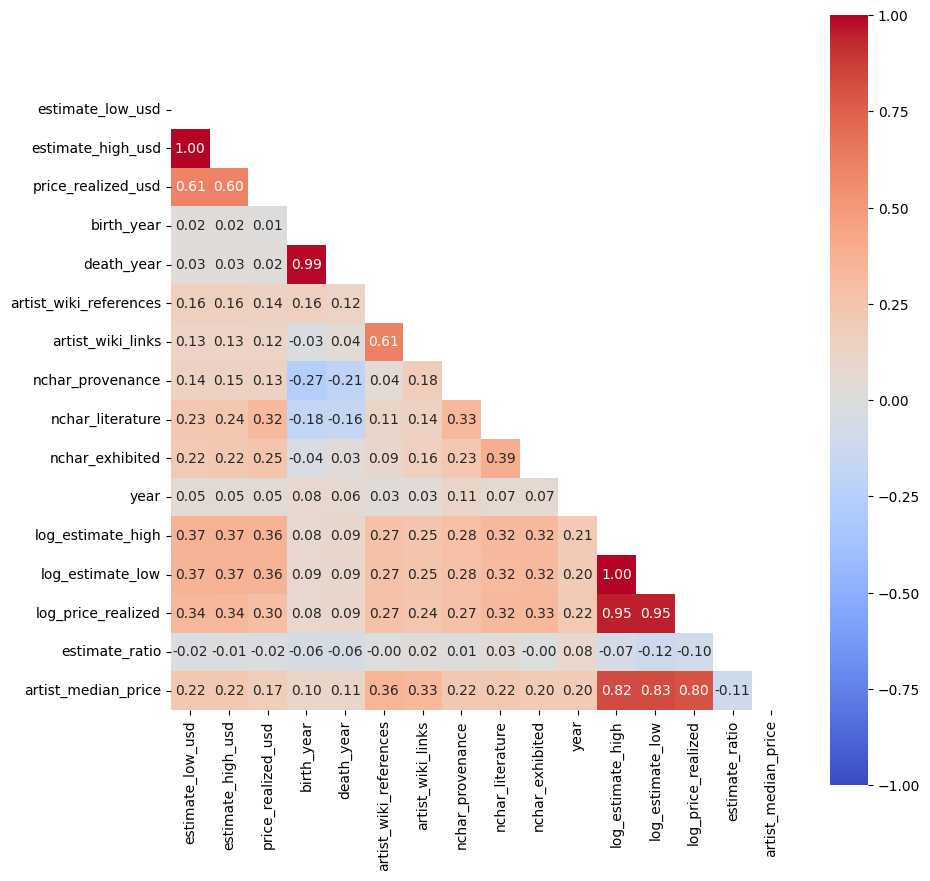

In [21]:
def correlation_graph (input):
    # Compute the correlation matrix
    corr = input.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(10, 10))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True, annot=True, fmt='.2f', annot_kws={'size': 10})

correlation_graph(train_set)

It is necessary to change and drop certain rows after all that as well, since our models cannot interpret string inputs.

In [22]:
def change_dtype_final(df):

    # Change into proper data types
    df['artist'] = df['artist'].astype('category')
    df['object_id'] = df['object_id'].astype('category')
    df['name'] = df['name'].astype('category')
    df['artist_most_common_nationality'] = df['artist_most_common_nationality'].astype('category')

    df = df.drop(['details', 'provenance', 'literature', 'exhibited', 'birth_death', 'artist_categories', 'object_id', 'date', 'estimate_low_usd', 'estimate_high_usd'], axis=1)
    
    if 'price_realized_usd' in df.columns:
        df = df.drop(['price_realized_usd'], axis=1)

    return df

# Scaling and Imputing

I chose the MinMax scaler because most of these values are not normally distributed, and for a while I was battling with getting negative predictions for art prices.

After some experimentation I decided that I should be predicting log-dollars instead of dollars, and then bringing the predictions back to units of dollars before submitting.

In [23]:
def impute_data(df, categorical_features, imputer=None):
    numerical_features = list(set(df.columns) - set(categorical_features))
    if imputer is None:
        # Fit the imputer on the training data
        imputer = SimpleImputer(strategy='median')
        imputer.fit(df[numerical_features])

    # Impute missing values with the median
    df_imputed = imputer.transform(df[numerical_features])

    # Convert the numpy array back to a dataframe
    df_imputed = pd.DataFrame(df_imputed, columns=numerical_features)

    # Fill in the original dataframe with imputed values
    df[numerical_features] = df_imputed

    return df, imputer


def scale_data_standard(df, categorical_features, scaler=None):
    numerical_features = list(set(df.columns) - set(categorical_features))
    if scaler is None:
        # Fit the scaler on the training data
        scaler = StandardScaler()
        scaler.fit(df[numerical_features])

    # Scale the numerical features using StandardScaler
    df_scaled = scaler.transform(df[numerical_features])

    # Convert the numpy array back to a dataframe
    df_scaled = pd.DataFrame(df_scaled, columns=numerical_features)

    # Fill in the original dataframe with imputed and scaled values
    df[numerical_features] = df_scaled

    return df, scaler


def scale_data_minmax(df, categorical_features, scaler=None):
    numerical_features = list(set(df.columns) - set(categorical_features))
    if scaler is None:
        # Fit the scaler on the training data
        scaler = MinMaxScaler()
        scaler.fit(df[numerical_features])

    # Scale the numerical features using MinMaxScaler
    df_scaled = scaler.transform(df[numerical_features])

    # Convert the numpy array back to a dataframe
    df_scaled = pd.DataFrame(df_scaled, columns=numerical_features)

    # Fill in the original dataframe with imputed and scaled values
    df[numerical_features] = df_scaled

    return df, scaler


I found label encoding doesn't hurt. I think this is because random forest model in particular does not care much about linearity or order.

In [24]:
def label_encode(df):
    le = LabelEncoder()

    categorical_features = ['artist', 'original_currency', 'auction', 'location', 'category', 'name', 'artist_most_common_nationality', 'month']

    for feature in categorical_features:
        df[feature] = le.fit_transform(df[feature])

    return df

# Re-importing data

After all that EDA and messing with dataframes, I would like to start fresh and re-import the data.

In [25]:
# Reset train_set back to original condition before EDA:

train = pd.read_csv('../input/the-price-of-art/train.csv')

train_set, validation_set = train_test_split(train, test_size=0.3, random_state=1)

This gives me the same split as the first time because the `random_state` is similar:

In [26]:
# Sample smaller for model selection and evaluation

train_set_small = train_set.sample(n=10000, random_state=1)
validation_set_small = validation_set.sample(n=10000, random_state=1)

Here is a "function of functions" that brings the data up to speed again.

In [27]:
# Define all pre-processing steps in once place

categorical_and_target_features = ['artist', 'original_currency', 'auction', 'location', 'category', 'name', 'artist_most_common_nationality', 'month', 'log_price_realized']

def preprocess_data(df):
    df = change_dtype_and_outliers(df)
    df = parse_artist_data(df)
    df = merge_wiki_data(df, artists_wiki_refs_nationalities, "name")
    df = engineer_features_basic(df)
    df = engineer_features_numeric(df)
    df = engineer_artist_median_price(df)
    df = change_dtype_final(df)
    df = label_encode(df)
    df = df, imputer = impute_data(df, categorical_and_target_features)
    df = df, scaler = scale_data_minmax(df, categorical_and_target_features)
    
    return df

In [28]:
train_set_small = preprocess_data(train_set_small)

And here I identify predictor and target variables:

In [29]:
X_train_set_small = train_set_small.drop(['log_price_realized'], axis=1) 
X_train_set_small = train_set_small.drop(categorical_and_target_features, axis=1)
y_train_set_small = train_set_small['log_price_realized'] # select log of price_realized_usd column as the target variable

# Choosing hyperparameters

First, here are some basic models with no special hyperparameters (defaults are used):

In [30]:
ridge_pipeline = Pipeline([
    ("model", Ridge())
])

lasso_pipeline = Pipeline([
    ("model", Lasso())
])

rf_pipeline = Pipeline([
    ("model", RandomForestRegressor())
])

pipelines = [ridge_pipeline, lasso_pipeline, rf_pipeline]

And here is a function I have been using for graphically comparing the results of cross-validation using RMSLE:

In [31]:
#Function for comparing cross-validation using chosen scoring metric, in this case RMSLE

def evaluate_models(X, y, pipelines, yourtext):

    rmsle_scorer = make_scorer(mean_squared_log_error, squared=False)
    
    # create empty lists to store results
    models = ['Ridge', 'LASSO', 'Random Forest']
    cv_scores = []

    # perform K-fold cross validation for each pipeline and store the results
    for i, pipeline in enumerate(pipelines):
        cv_score = cross_val_score(pipeline, X, y, cv=5, scoring=rmsle_scorer).mean()
        cv_scores.append(cv_score)

    # create a dictionary with the results for each model
    results = {'Model': models, 'CV Score': cv_scores}

    # create a Seaborn barplot with the CV scores displayed inside each bar
    sns.set_style('whitegrid')
    ax = sns.barplot(x='Model', y='CV Score', data=results, color='blue')
    ax.set_ylim([0, 1])
    ax.set_title('RMSLE for Different Models: '+ yourtext)
    ax.set_xlabel('Model')
    ax.set_ylabel('RMSLE')

    for bar in ax.containers:
        ax.bar_label(bar, label_type='edge', fontsize=10)

    plt.show()

It shows Random Forest doing pretty well with default hyperparameters, and LASSO not doing so well.

**Do not be mistaken by the low RMSLE.**

Remember that I switched from using `price_realized_usd` to its logged equivalent, `log_price_realized` as a target variable.

That means the RMSLE is going to be an order of magnitude lower even though the prediction are not actually better.

RMSLE is still useful for comparison between models that use the same target variable.

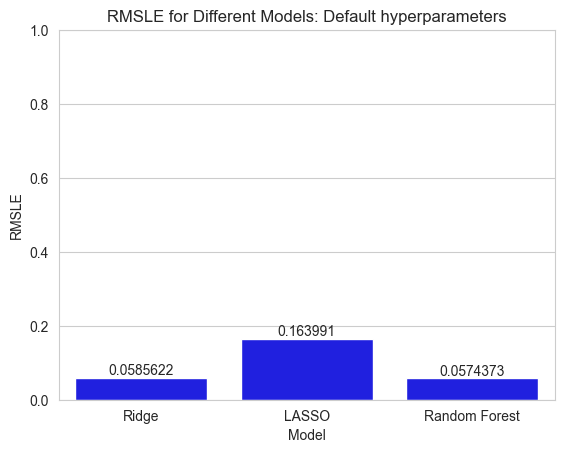

In [32]:
evaluate_models(X_train_set_small, y_train_set_small, pipelines=pipelines, yourtext="Default hyperparameters")

Based on some offline parameter testing using the `train_set`, I found some numerical ranges to hone in on using RandomizedSearchCV and `np.linspace()`, which creates an array of length specified (in my case, 25)  between numeric brackets of your choosing.

The RandomizedSearchCV is doing 5-fold cross-validation to find the best hyperparameters over 500 iterations. I have set the number of iterations that high because it is required for a usable data for graphing purposes, as you will see below.

The implemenation of SkLearn's RandomizedSearchCV feature below is a little bit irregular. In some cases it is actually doing the same thing as an exhaustive GridSearchCV. But - I found it works for what I need it for, and at least on the surface it behaves similarly to regular (and slow) GridSearchCV.

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso
import numpy as np

ridge_params = {
    'alpha': np.linspace(0.01, 10, num=25),
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

lasso_params = {
    'alpha': np.linspace(0.001, 1, num=25),
    'max_iter': [100, 500, 2000],
    'selection': ['cyclic', 'random']
}

# Define the parameter grid for Random Forest
rf_params = {
    'n_estimators': [500, 1000, 2000],
    'max_depth': [3, 5, 10, None]
}

# Define the model to use for the search
ridge_model = Ridge()
lasso_model = Lasso()
rf_model = RandomForestRegressor()

# Define the number of iterations for the search
n_iter = 500

# Perform the random grid search for Ridge regression
ridge_search = RandomizedSearchCV(
    ridge_model,
    param_distributions=ridge_params,
    n_iter=n_iter,
    cv=5,
    random_state=1,
    n_jobs=-1
)

# Perform the random grid search for Lasso regression
lasso_search = RandomizedSearchCV(
    lasso_model,
    param_distributions=lasso_params,
    n_iter=n_iter,
    cv=5,
    random_state=1,
    n_jobs=-1
)

# Perform the random grid search for Random Forest
rf_search = RandomizedSearchCV(
    rf_model,
    param_distributions=rf_params,
    n_iter=n_iter,
    cv=5,
    random_state=1,
    n_jobs=-1
)


# Fit the searches to the data
ridge_search.fit(X_train_set_small, y_train_set_small)
lasso_search.fit(X_train_set_small, y_train_set_small)
rf_search.fit(X_train_set_small, y_train_set_small)

# Print the best parameters found for Ridge regression
print("Best Parameters for Ridge Regression: ", ridge_search.best_params_)

# Print the best parameters found for Lasso regression
print("Best Parameters for Lasso Regression: ", lasso_search.best_params_)

# Print the best parameters found for Lasso regression
print("Best Parameters for Random Forest: ", rf_search.best_params_)


Best Parameters for Ridge Regression:  {'solver': 'saga', 'alpha': 1.675}
Best Parameters for Lasso Regression:  {'selection': 'random', 'max_iter': 500, 'alpha': 0.001}
Best Parameters for Random Forest:  {'n_estimators': 1000, 'max_depth': 10}


Remember that this is just on the `train_set`, and although it is doing cross-validation, there is a chance we are getting misleading results due to the Wikipedia searching, median-finding, and other things I did specific to the `train_set` data.

Here are some plots which exhibit CV score for each combination of hyperparameters:

Text(0.5, 1.0, 'Ridge Regression Hyperparameter Tuning')

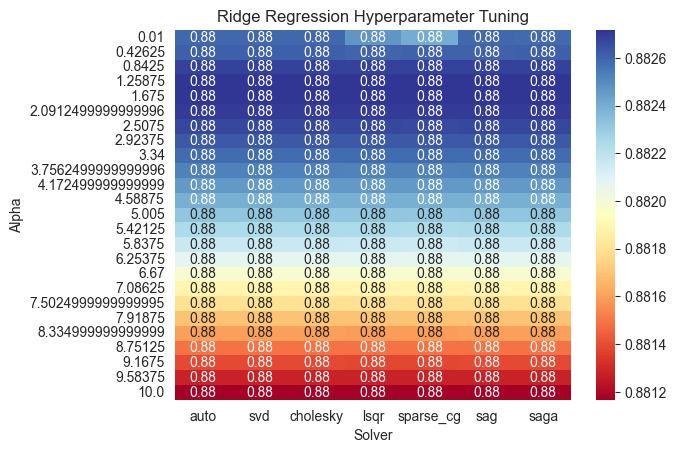

In [34]:
import seaborn as sns

# Get the results of the searches
ridge_results = ridge_search.cv_results_
lasso_results = lasso_search.cv_results_
rf_results = rf_search.cv_results_

# Extract the mean test scores and reshape into a matrix for Ridge regression
ridge_scores = np.array(ridge_results['mean_test_score']).reshape(len(ridge_params['alpha']), len(ridge_params['solver']))

# Create a heatmap of the mean test scores for Ridge regression
sns.heatmap(ridge_scores, annot=True, xticklabels=ridge_params['solver'], yticklabels=ridge_params['alpha'], cmap='RdYlBu')
plt.xlabel('Solver')
plt.ylabel('Alpha')
plt.title('Ridge Regression Hyperparameter Tuning')


Text(0.5, 1.0, 'Lasso Regression Hyperparameter Tuning')

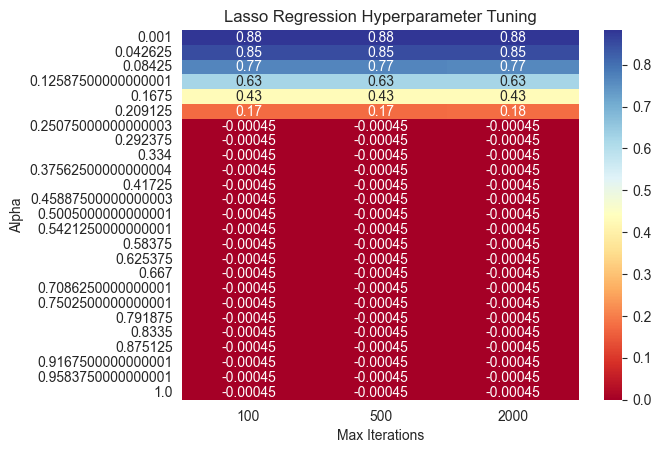

In [35]:
# Extract the mean test scores and reshape into a matrix for Lasso regression
lasso_scores = np.array(lasso_results['mean_test_score']).reshape(len(lasso_params['alpha']), len(lasso_params['max_iter']), len(lasso_params['selection']))

# Create a heatmap of the mean test scores for Lasso regression
sns.heatmap(lasso_scores.mean(axis=2), annot=True, xticklabels=lasso_params['max_iter'], yticklabels=lasso_params['alpha'], cmap='RdYlBu')
plt.xlabel('Max Iterations')
plt.ylabel('Alpha')
plt.title('Lasso Regression Hyperparameter Tuning')

Text(0.5, 1.0, 'Random Forest Hyperparameter Tuning')

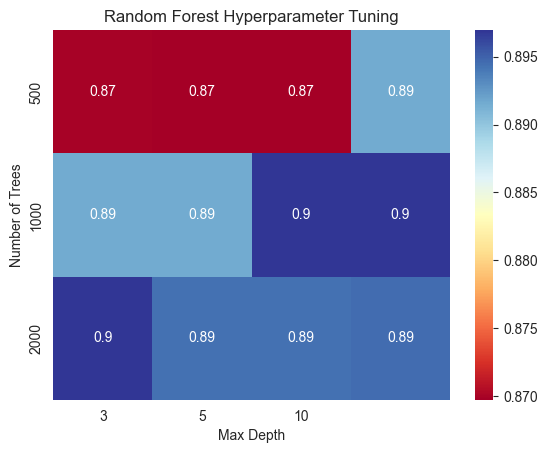

In [36]:
# Extract the mean test scores and reshape into a matrix for Random Forest
rf_scores = np.array(rf_results['mean_test_score'].reshape(len(rf_params['n_estimators']), len(rf_params['max_depth'])))
#lasso_scores = np.array(lasso_results['mean_test_score']).reshape(len(lasso_params['alpha']), len(lasso_params['max_iter']), len(lasso_params['selection']))

sns.heatmap(rf_scores, annot=True, xticklabels=rf_params['max_depth'], yticklabels=rf_params['n_estimators'], cmap='RdYlBu')
plt.xlabel('Max Depth')
plt.ylabel('Number of Trees')
plt.title('Random Forest Hyperparameter Tuning')

The output of this graph makes me think that 1000 trees is better than 500, even though 500 was technically chosen as the 'best' parameter. Now, to check the improvement of models after changing to new hyperparameters. I will establish them with the selected hyperparameters:

In [37]:
ridge_pipeline = Pipeline([
    ("model", Ridge(alpha=1.675, solver='saga'))
])

lasso_pipeline = Pipeline([
    ("model", Lasso(alpha=.001, max_iter=500, selection='random'))
])

rf_pipeline = Pipeline([
    ("model", RandomForestRegressor(max_depth=10, n_estimators = 1000))
])

pipelines = [ridge_pipeline, lasso_pipeline, rf_pipeline]

It looks like Random Forest is still on top:

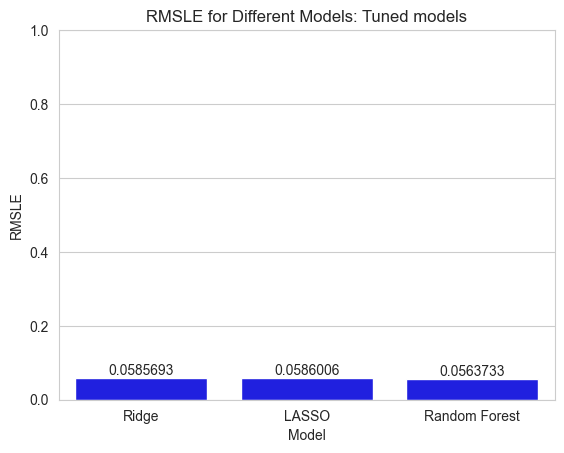

In [38]:
evaluate_models(X_train_set_small, y_train_set_small, pipelines=pipelines, yourtext="Tuned models")

# Caution about overfitting

If I had not held back a validation set, I feel I would have 'leaked' quite a bit of data due to variables like `artist_most_common_nationality`, etc.

I have kept the `validation_set` undisturbed, however:

In [39]:
list(validation_set)

['object_id',
 'artist',
 'original_currency',
 'height_cm',
 'width_cm',
 'auction',
 'location',
 'details',
 'provenance',
 'literature',
 'exhibited',
 'category',
 'date',
 'estimate_low_usd',
 'estimate_high_usd',
 'price_realized_usd']

To recap, this is the treatment I am giving new, unseen data:

 - `change_dtype_and_outliers()` - In my perspective, it's OK if this just removes local outliers by the 99th quintile
 - `parse_artist_data()` - Regular expressions to get `name`, `birth_date`...
 - `merge_wiki_data()` - We are joining on an external dataset of ~900 artists, but I made sure none of them came from this `validation_set`
 - `engineer_features_basic()` - More simple regular expressions
 - `engineer_features_numeric()` - Yet more simple regular expressions
 - `engineer_artist_median_price()` - I was considering using median prices as seen in the whole training data, but paused for concern about overfitting. Maybe later?
 - `change_dtype_final()` - Just data cleaning.
 - `label_encode` - I want to include categorical information, and since random forest does not assume linearity, this hopefully works.
 - `scale_data_minmax()` and `impute_data()` - These two functions have options to using imputations and scales from either training or validation data. But I'm leaving them to do their thing 'locally' for now, and not look back at training data.


Here is that treatment applied on the fresh validation_set:

In [40]:
validation_set = preprocess_data(validation_set)

In [41]:
#Identify predictor and target variables
X_validation_set = validation_set.drop(['log_price_realized'], axis=1) 
X_validation_set = validation_set.drop(categorical_and_target_features, axis=1)
y_validation_set = validation_set['log_price_realized'] # select log of price_realized_usd column as the target variable

I want to make sure the models which have been fit on the `train_set` generalize well to the `validation_set`. First, I'll run through all the steps to preprocess it. Remember that before I was only working with `train_set_small`, a small subset, for model selection purposes.

In [42]:
train = pd.read_csv('../input/the-price-of-art/train.csv')

train_set, validation_set = train_test_split(train, test_size=0.3, random_state=1)

train_set = preprocess_data(train_set)

X_train_set = train_set.drop(['log_price_realized'], axis=1) 
X_train_set = train_set.drop(categorical_and_target_features, axis=1)
y_train_set = train_set['log_price_realized'] # select log of price_realized_usd column as the target variable

# Fit models on the training set
for pipeline in pipelines:
    pipeline.fit(X_train_set, y_train_set)

Now that the models are fit on `X_train_set` and `y_train_set`, I can evaluate their RMSLE for predictions on the yet-unseen `X_validation_set`:

In [43]:
for pipeline in pipelines:
    y_pred = pipeline.predict(X_validation_set)
    rmsle = mean_squared_log_error(y_validation_set, y_pred, squared=False)
    print(f"{pipeline.named_steps['model'].__class__.__name__}:")
    print(f"RMSLE: {rmsle:.2f}\n")

Ridge:
RMSLE: 0.06

Lasso:
RMSLE: 0.06

RandomForestRegressor:
RMSLE: 0.06



And make predictions:

In [44]:
y_pred_rf = rf_pipeline.predict(X_validation_set)

And now I can see what kind of outcome I've got:

In [45]:
def reverse_log_price(log_price):
    return np.exp(log_price)

predicted_and_actual = pd.DataFrame({'predicted_price_usd': reverse_log_price(y_pred_rf),
                   'actual_price_usd': reverse_log_price(y_validation_set)})
                   
predicted_and_actual_log = pd.DataFrame({'predicted_price_usd': y_pred_rf,
                   'actual_price_usd': y_validation_set})

# define a function to calculate RMSLE
def rmsle(predicted, actual):
    return (mean_squared_log_error(actual, predicted, squared=False))

rmsle_value = rmsle(predicted_and_actual['predicted_price_usd'], predicted_and_actual['actual_price_usd'])
rmsle_value_log = rmsle(predicted_and_actual_log['predicted_price_usd'], predicted_and_actual_log['actual_price_usd'])
print("RMSE, prediction in log-USD: ", rmsle_value_log)
print("RMSE, predictions in USD: ", rmsle_value)

RMSE, prediction in log-USD:  0.057578297389325635
RMSE, predictions in USD:  0.6066687339052452


# Final Predictions

It's now time to make some actual predictions with my chosen model.

In [46]:
train = pd.read_csv('../input/the-price-of-art/train.csv')
test = pd.read_csv('../input/the-price-of-art/test.csv')

test = preprocess_data(test)
train = preprocess_data(train)

#Identify predictor and target variables
X_train = train.drop(['log_price_realized'], axis=1) 
X_train = train.drop(categorical_and_target_features, axis=1)
y_train = train['log_price_realized'] # select log of price_realized_usd column as the target variable

# Fit the pipeline on all training data:
rf_pipeline.fit(X_train, y_train)

test = pd.read_csv('../input/the-price-of-art/test.csv')
test = preprocess_data(test)
test = test.drop(['artist', 'original_currency', 'auction', 'location', 'category', 'name', 'artist_most_common_nationality', 'month'], axis=1)

y_pred_final = rf_pipeline.predict(test)

In [47]:
test = pd.read_csv('../input/the-price-of-art/test.csv')
# Format submission
submission = pd.DataFrame({'object_id': test['object_id'],
                   'price_realized_usd': reverse_log_price(y_pred_final)})

# Submit to Kaggle
submission.to_csv('submission.csv', index=False)

# More Thoughts

I hope that I got the gist of Random Forest. I have been thinking about:

- **Feature selection** - I created plenty of features, but did not really select any to remove. Going forward, I could use sklearn's `SelectFromModel` feature to choose features based on ['impurity'.](https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f), but it also seems like it doesn't hurt to leave everything in.

- **Unseen data** - The median values I extracted are part of the preprocessing step, not stored from previous information. The same goes with scaling, outlier correction, and median imputation. I tinkered with saving those fitted transformers and applying them to new data, but I was using so many different models that it seemed impractical. Cross-validations are very long, especially using Random Forest.

- **Feature importance** - The graphs below demonstrate certain varaibles' effect on model score when a single feature value is randomly shuffled. Nearly all of them make it seem like my features only had a modest effect. Too bad!

- **Wiki data** - Was this allowed in the spirit of the competition? I hope so - there are only so many prominent artsts out there, and knowing their level of fame could be helpful with any new unseen data. I feel like using this data was a way to give the model more information about art in general, and it seems to generalize OK to new data - although it doesn't have the dramatic effect I wish it did.

In [48]:
from sklearn.inspection import permutation_importance

def graph_perm_importance (pipeline_arg, X, y):
    pipeline_arg.fit(X, y)
    result = permutation_importance(pipeline_arg, X, y)
    sorted_idx = result.importances_mean.argsort()[::-1]
    sns.barplot(x=result.importances_mean[sorted_idx], y=X.columns[sorted_idx])

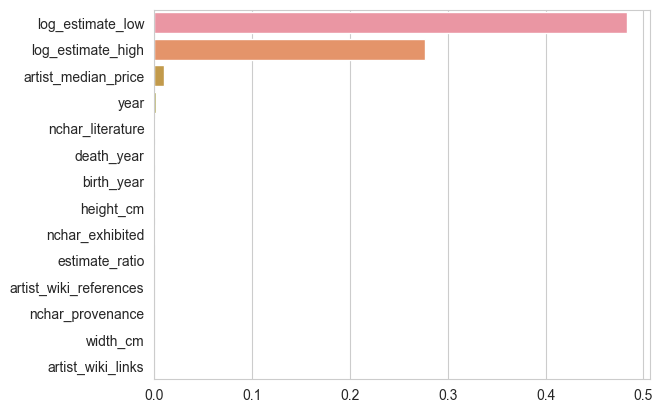

In [49]:
graph_perm_importance(ridge_pipeline, X_train_set, y_train_set)

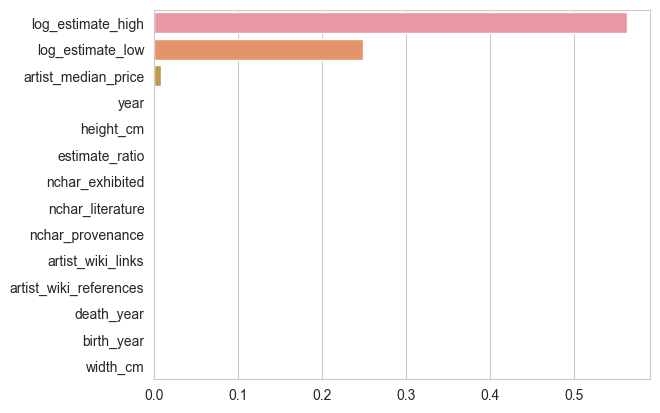

In [50]:
graph_perm_importance(lasso_pipeline, X_train_set, y_train_set)

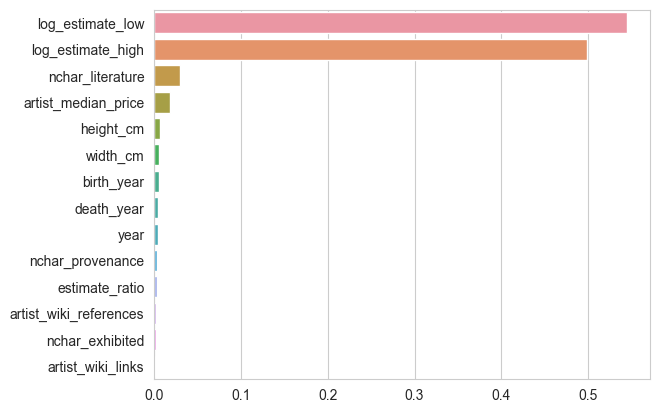

In [51]:
graph_perm_importance(rf_pipeline, X_train_set_small, y_train_set_small)

# Linear Regression Recap

Due to the okay-enough results from the Random Forest classifier, I want to return to linear regression and see if it can do better with the extra feature engineering I have done.

This will not need scaling, so that has been removed from my preprocessing. I am also not doing label encoding because that may violate linearity.

But, because I am no longer using tree-based models, I need to specify interaction variables manually, and will do so.

My best linear model in R was:

$$
\begin{equation}
\begin{split}
lm(\log(price\_realized\_usd) \sim \log(estimate\_high\_usd) + \log(estimate\_low\_usd) + \\ \log(estimate\_low\_usd) \times \log(estimate\_high\_usd) + height\_cm + width\_cm + \\ nchar\_literature + nchar\_provenance + nchar\_exhibited + month + location)
\end{split}
\end{equation}
$$

I am attempting to remake that interaction term with `log_estimate_interaction1` below. 

On the other hand, `popularity_interaction` is a new interaction term I got an idea from background reading about the subject.

In [52]:
def engineer_features_linear_interactions(df):

    # Add the interaction features for linear regression
    df['log_estimate_interaction1'] = df['log_estimate_low'] * df['log_estimate_high']
    df['popularity_interaction'] = df['artist_wiki_references'] * df['artist_wiki_links'] * df['nchar_literature']

    return df

In [53]:
def preprocess_data_linear(df):
    categorical_and_target_features = ['artist', 'original_currency', 'auction', 'location', 'category', 'name', 'artist_most_common_nationality', 'month', 'log_price_realized']

    df = change_dtype_and_outliers(df)
    df = parse_artist_data(df)
    df = merge_wiki_data(df, artists_wiki_refs_nationalities, "name")
    df = engineer_features_basic(df)
    df = engineer_features_numeric(df)
    df = engineer_artist_median_price(df)
    #df = label_encode(df) # Leaving label encoding out, because it's not great for linear models.
    df = engineer_features_linear_interactions(df)
    df = change_dtype_final(df)
    df = df, imputer = impute_data(df, categorical_and_target_features)
    #df = df, scaler = scale_data_minmax(df, categorical_and_target_features) # No scaling required, either.
    #df = df, scaler = scale_data_standard(df, categorical_and_target_features)

    return df

In [54]:
# Reset train_set back to original condition before EDA:

train = pd.read_csv('../input/the-price-of-art/train.csv')

train_set, validation_set = train_test_split(train, test_size=0.3, random_state=1)

train_set = preprocess_data_linear(train_set)
validation_set = preprocess_data_linear(validation_set)

Here, I use `included_in_linear_regression` to define what variabels go into the regression:

In [55]:
included_in_linear_regression = ['log_estimate_high', 'log_estimate_low', 'height_cm', 'nchar_literature', 'nchar_exhibited', 'nchar_provenance', 'artist_wiki_references', 'artist_wiki_links', 'artist_median_price', 'log_price_realized', 'month', 'year', 'birth_year', 'death_year', 'popularity_interaction', 'log_estimate_interaction1', 'estimate_ratio']

train_set_linear = train_set[included_in_linear_regression]
validation_set_linear = validation_set[included_in_linear_regression]

In [56]:
X_train_set_linear = train_set_linear.drop(['log_price_realized'], axis=1) 
y_train_set_linear = train_set_linear['log_price_realized'] # select log of price_realized_usd column as the target variable

X_validation_set_linear = validation_set_linear.drop(['log_price_realized'], axis=1) 
y_validation_set_linear = validation_set_linear['log_price_realized'] # select log of price_realized_usd column as the target variable

In [57]:
from sklearn.linear_model import LinearRegression

#Establish linear model pipeline

linear_pipeline = Pipeline([
    ("model", LinearRegression())
])

# Fit the linear regression model
linear_model = linear_pipeline.fit(X_train_set_linear, y_train_set_linear)

y_pred_linear = linear_model.predict(X_validation_set_linear)


In [58]:
predicted_and_actual = pd.DataFrame({'predicted_price_usd': reverse_log_price(y_pred_linear),
                   'actual_price_usd': reverse_log_price(y_validation_set)})
                   
predicted_and_actual_log = pd.DataFrame({'predicted_price_usd': y_pred_linear,
                   'actual_price_usd': y_validation_set})

On the same split of data, it comes out better than the Random Forest model, which had these results:

 - RMSE, prediction in log-USD:  0.06073276019988042
 - RMSE, predictions in USD:  0.6341516155223436

In [59]:
rmsle_value = rmsle(predicted_and_actual['predicted_price_usd'], predicted_and_actual['actual_price_usd'])
rmsle_value_log = rmsle(predicted_and_actual_log['predicted_price_usd'], predicted_and_actual_log['actual_price_usd'])
print("RMSE, prediction in log-USD: ", rmsle_value_log)
print("RMSE, predictions in USD: ", rmsle_value)

RMSE, prediction in log-USD:  0.05712923107313651
RMSE, predictions in USD:  0.6064222433909512


Here are the feature importances:

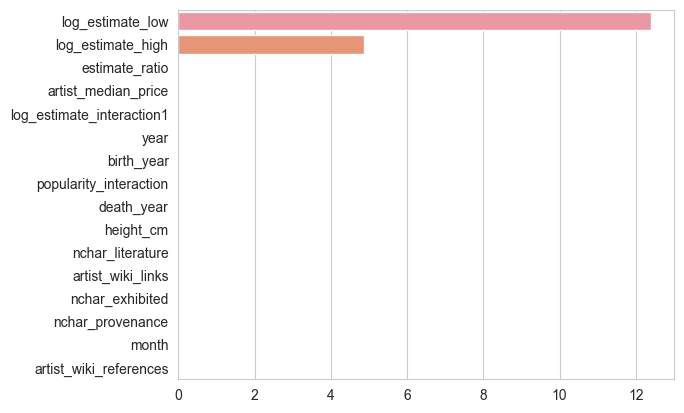

In [60]:
graph_perm_importance(linear_pipeline, X_validation_set_linear, y_validation_set)

Overall, I'm looking forward to finding out if the Random Forest, LASSO, or Ridge models can be improved more. If you've read through this and found and problems or have recommendations, please feel free to message me.